In [1]:
import tensorflow as tf
import keras 
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm
import re
from keras.preprocessing.image import img_to_array

In [3]:
# to get the files in proper order
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)
# defining the size of the image
SIZE = 256
color_img = []
path = r'C:\Users\kumar\imgforvs\inpainting\data\train\color'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):    
        if i == '2200.jpg':
            break
#             pass
        else:    
            img = cv2.imread(path + '/'+i,1)
            # open cv reads images in BGR format so we have to convert it to RGB
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            #resizing image
            img = cv2.resize(img, (SIZE, SIZE))
            img = img.astype('float32') / 255.0
            color_img.append(img_to_array(img))


masked_img = []
path = r'C:\Users\kumar\imgforvs\inpainting\data\train\color'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):
         if i == '2200.jpg':
            break
#               pass
         else: 
            mask = np.full((SIZE,SIZE,3), 255, dtype = np.uint8)
            for _ in range(np.random.randint(1, 10)):
                x1, x2 = np.random.randint(1, SIZE), np.random.randint(1, SIZE)
                y1, y2 = np.random.randint(1, SIZE), np.random.randint(1, SIZE)
                thickness = np.random.randint(5, 10)
                cv2.line(mask, (x1, y1), (x2, y2), (1, 1, 1), thickness)
            img = cv2.imread(path + '/'+i,1)
#             print(img.shape)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            #resizing image
            img = cv2.resize(img, (SIZE, SIZE))
#             img = img.astype('float32') / 255.0
            img = np.asarray(img)
#             print(mask.shape,img.shape)
            masked = cv2.bitwise_and(img, mask)
#             plt.imshow(masked_image)
            masked_img.append(masked.astype('float32') / 255.0)

 70%|███████   | 1401/2000 [00:01<00:00, 701.32it/s]


In [4]:
color_dataset=tf.data.Dataset.from_tensor_slices(np.array(color_img[:2000])).batch(8)
masked_dataset=tf.data.Dataset.from_tensor_slices(np.array(masked_img[:2000])).batch(8)

color_dataset_t=tf.data.Dataset.from_tensor_slices(np.array(color_img[2000:])).batch(4)
masked_dataset_t=tf.data.Dataset.from_tensor_slices(np.array(masked_img[2000:])).batch(4)

In [5]:
example_color = next(iter(color_dataset))
example_masked = next(iter(masked_dataset))

In [6]:
def plot_images(a = 4):
    
    for i in range(a):
        plt.figure(figsize = (10,10))
        plt.subplot(121)
        plt.title('color')
        plt.imshow(example_color[i] )

        plt.subplot(122)
        plt.title('masked')
        plt.imshow(example_masked[i])
        plt.show()

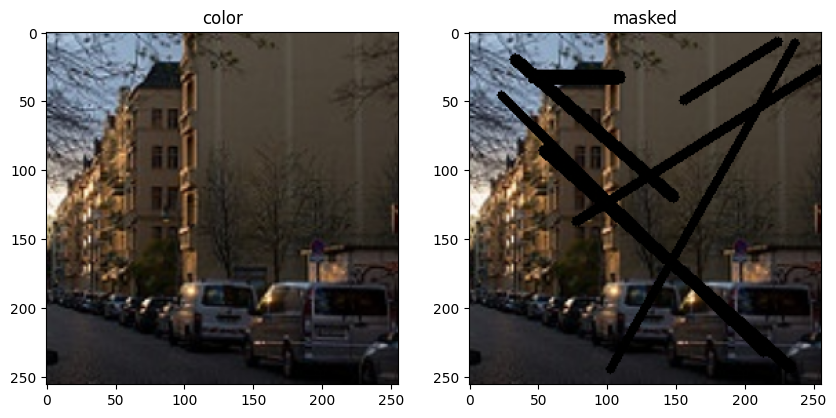

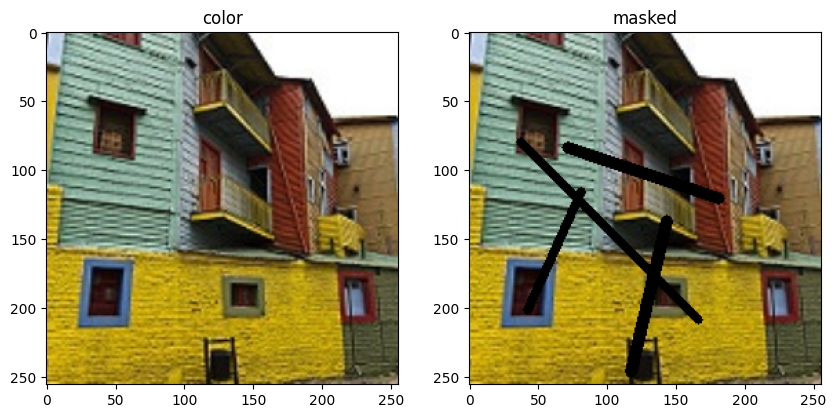

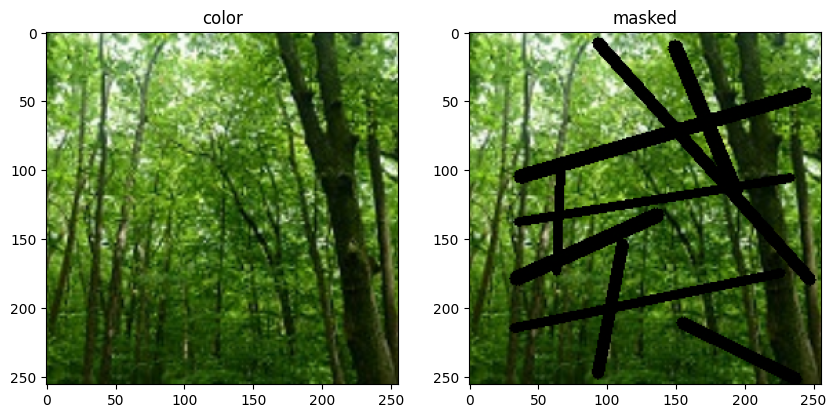

In [7]:
plot_images(3)

In [8]:
def downsample(filters, size, apply_batchnorm=True):
  
  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer='he_normal', use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

def upsample(filters, size, apply_dropout=False):
  

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer='he_normal',
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result  

In [9]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256,256,3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
    downsample(128, 4), # (bs, 64, 64, 128)
    downsample(256, 4), # (bs, 32, 32, 256)
    downsample(512, 4), # (bs, 16, 16, 512)
    downsample(512, 4), # (bs, 8, 8, 512)
    downsample(512, 4), # (bs, 4, 4, 512)
    downsample(512, 4), # (bs, 2, 2, 512)
    downsample(512, 4), # (bs, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
    upsample(512, 4), # (bs, 16, 16, 1024)
    upsample(256, 4), # (bs, 32, 32, 512)
    upsample(128, 4), # (bs, 64, 64, 256)
    upsample(64, 4), # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(3, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)


In [10]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
  down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
  down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)


In [11]:
from tensorflow.keras.utils import plot_model

In [12]:
generator = Generator()
generator.summary()


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 128, 128,  │      3,072 │ input_layer[0][0] │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 64, 64,    │    131,584 │ sequential[0][0]  │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 32, 32,    │    525,312 │ sequential_1[0][… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 16, 16,    │  2,099,200 │ sequential_2[0][… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_4        │ (None, 8, 8, 512) │  4,196,352 │ sequential_3[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_5        │ (None, 4, 4, 512) │  4,196,352 │ sequential_4[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_6        │ (None, 2, 2, 512) │  4,196,352 │ sequential_5[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_7        │ (None, 1, 1, 512) │  4,196,352 │ sequential_6[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_8        │ (None, 2, 2, 512) │  4,196,352 │ sequential_7[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 2, 2,      │          0 │ sequential_8[0][… │
│ (Concatenate)       │ 1024)             │            │ sequential_6[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_9        │ (None, 4, 4, 512) │  8,390,656 │ concatenate[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 4, 4,      │          0 │ sequential_9[0][… │
│ (Concatenate)       │ 1024)             │            │ sequential_5[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_10       │ (None, 8, 8, 512) │  8,390,656 │ concatenate_1[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 8, 8,      │          0 │ sequential_10[0]… │
│ (Concatenate)       │ 1024)             │            │ sequential_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_11       │ (None, 16, 16,    │  8,390,656 │ concatenate_2[0]… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 16, 16,    │          0 │ sequential_11[0]

 Total params: 54,425,859 (207.62 MB)

 Trainable params: 54,414,979 (207.58 MB)

 Non-trainable params: 10,880 (42.50 KB)

In [13]:
discriminator = Discriminator()
discriminator.summary()

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ target_image        │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_7       │ (None, 256, 256,  │          0 │ input_image[0][0… │
│ (Concatenate)       │ 6)                │            │ target_image[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_15       │ (None, 128, 128,  │      6,144 │ concatenate_7[0]… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_16       │ (None, 64, 64,    │    131,584 │ sequential_15[0]… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_17       │ (None, 32, 32,    │    525,312 │ sequential_16[0]… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 34, 34,    │          0 │ sequential_17[0]… │
│ (ZeroPadding2D)     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 31, 31,    │  2,097,152 │ zero_padding2d[0… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 31,    │      2,048 │ conv2d_11[0][0]   │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_11      │ (None, 31, 31,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 33, 33,    │          0 │ leaky_re_lu_11[0… │
│ (ZeroPadding2D)     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 30, 30, 1) │      8,193 │ zero_padding2d_1… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,770,433 (10.57 MB)

 Trainable params: 2,768,641 (10.56 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [14]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

LAMBDA = 100

def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [15]:
def train_step(input_image, target, epoch):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

 

In [16]:
import time
def fit(train_ds, epochs,):
  for epoch in range(epochs):
    start = time.time()

    print("Epoch: ", epoch+1)

    # Train
    for n, (input_image, target) in train_ds.enumerate():
      
      train_step(input_image, target, epoch)
    print()

  

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))
  


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.86858785..0.7839229].


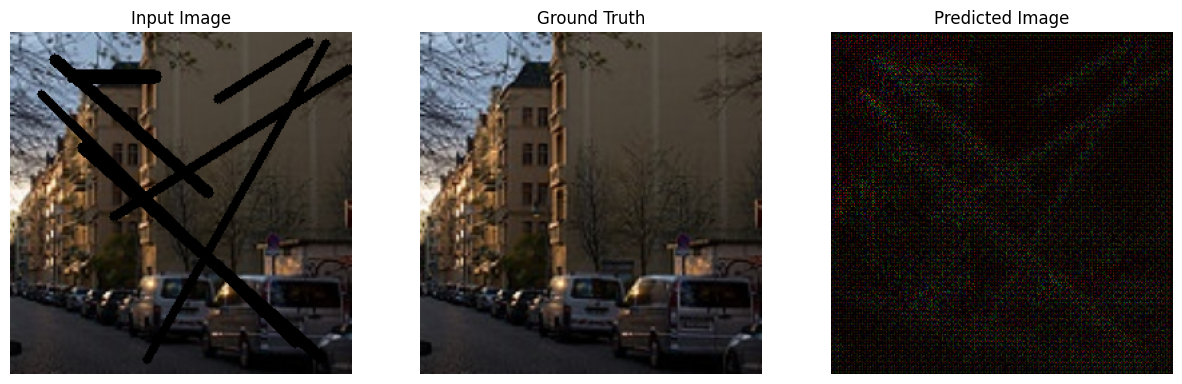

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9535979..0.8615726].


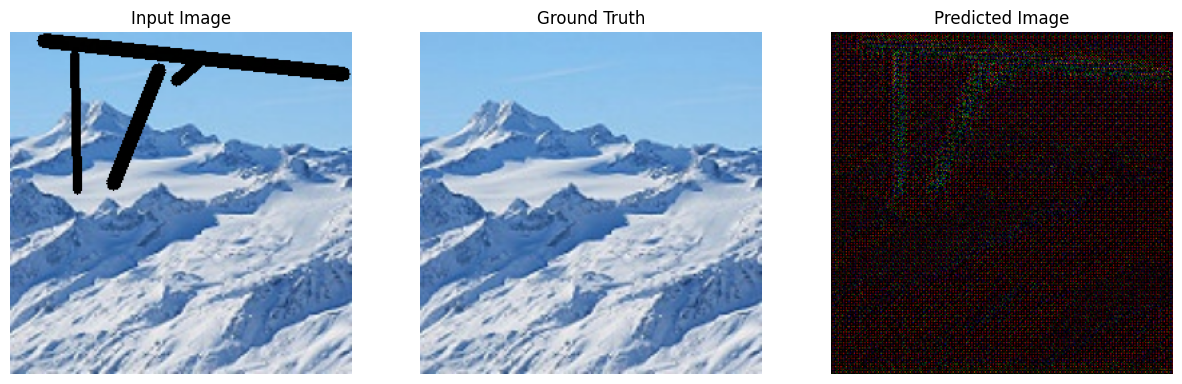

In [17]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15,15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i])
    plt.axis('off')
  plt.show()

for example_input, example_target in tf.data.Dataset.zip((masked_dataset,color_dataset)).take(2):
  generate_images(generator, example_input, example_target)


In [18]:
fit(tf.data.Dataset.zip((masked_dataset, color_dataset)),
    epochs = 1)

Epoch:  1

Time taken for epoch 1 is 977.0834908485413 sec



In [19]:
import os
from IPython.display import display
from PIL import Image
os.makedirs('outputs', exist_ok=True)

def generate_images_and_show(model, test_input, tar, idx=0):
    prediction = model(test_input, training=False)
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(15,15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        ax = fig.add_subplot(1, 3, i+1)
        ax.set_title(title[i])
        ax.imshow(display_list[i])
        ax.axis('off')

    out_path = os.path.abspath(f"outputs/generated_{idx+1}.png")
    fig.savefig(out_path, bbox_inches='tight')
    plt.close(fig)

    img = Image.open(out_path)
    display(img)
    print('Saved:', out_path)

for idx, (example_input, example_target) in enumerate(tf.data.Dataset.zip((masked_dataset_t,color_dataset_t)).take(1)):
    generate_images_and_show(generator, example_input, example_target, idx)


Kernel cwd: c:\Users\kumar\OneDrive\Desktop\imginvs

Listing files in cwd:

Listing files in outputs/:
c:\Users\kumar\OneDrive\Desktop\imginvs\outputs\api_result.png
c:\Users\kumar\OneDrive\Desktop\imginvs\outputs\debug_binmask.png
c:\Users\kumar\OneDrive\Desktop\imginvs\outputs\generated_verified_fallback.png
c:\Users\kumar\OneDrive\Desktop\imginvs\outputs\inpainted_telea.png
Saved: c:\Users\kumar\OneDrive\Desktop\imginvs\outputs\generated_verified_fallback.png (267825 bytes)


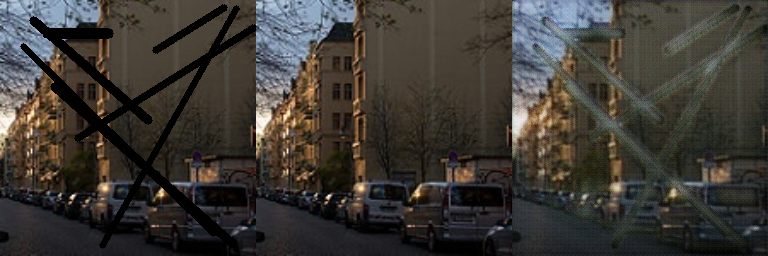


Listing outputs/ directory:
c:\Users\kumar\OneDrive\Desktop\imginvs\outputs\api_result.png
c:\Users\kumar\OneDrive\Desktop\imginvs\outputs\debug_binmask.png
c:\Users\kumar\OneDrive\Desktop\imginvs\outputs\generated_verified_fallback.png
c:\Users\kumar\OneDrive\Desktop\imginvs\outputs\inpainted_telea.png


In [20]:
import os
print('Kernel cwd:', os.getcwd())
print('\nListing files in cwd:')
for p in sorted([p for p in os.listdir('.') if p.lower().endswith('.png')]):
    print(os.path.abspath(p))

outs = 'outputs'
if os.path.exists(outs):
    print('\nListing files in outputs/:')
    for p in sorted(os.listdir(outs)):
        if p.lower().endswith('.png'):
            print(os.path.abspath(os.path.join(outs, p)))
else:
    print('\noutputs/ directory does not exist in cwd')

# Robust save + verify (improved, memory-safe)
import gc
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

outs_dir = os.path.join(os.getcwd(), 'outputs')
os.makedirs(outs_dir, exist_ok=True)

# Helper to convert float image (either in [0,1] or [-1,1]) to uint8
def to_uint8(img):
    img = np.array(img, dtype=np.float32)
    # If values look like tanh output in [-1,1], convert to [0,1]
    if img.min() < -0.5 and img.max() <= 1.0:
        img = (img + 1.0) / 2.0
    # If values are larger than 1.0, clip after normalization attempt
    img = np.clip(img, 0.0, 1.0)
    img = (img * 255.0).astype('uint8')
    return img

# Compose and save function
def compose_and_save(input_img, gt_img, pred_img, out_path):
    a = to_uint8(input_img)
    b = to_uint8(gt_img)
    c = to_uint8(pred_img)
    # Ensure same height
    if a.shape != b.shape or a.shape != c.shape:
        # resize using PIL if shapes mismatch
        H, W = a.shape[0], a.shape[1]
        b = np.array(Image.fromarray(b).resize((W, H)))
        c = np.array(Image.fromarray(c).resize((W, H)))
    composed = np.concatenate([a, b, c], axis=1)
    Image.fromarray(composed).save(out_path)

# Memory-safe: fetch one small sample without materializing entire lists
def get_one_sample():
    # Prefer test datasets first, then train datasets
    for ds_pair in [(masked_dataset_t, color_dataset_t), (masked_dataset, color_dataset)]:
        try:
            # Take just one batch and one item from it
            for mi, ci in tf.data.Dataset.zip(ds_pair).take(1):
                return mi[0].numpy(), ci[0].numpy()
        except Exception:
            # continue to next option
            pass
    # Fallback to raw lists: DO NOT convert whole lists to np.array
    try:
        if isinstance(masked_img, list) and isinstance(color_img, list) and len(masked_img) > 0 and len(color_img) > 0:
            return np.array(masked_img[0]), np.array(color_img[0])
    except Exception:
        pass
    return None, None

# Get sample
in_img, gt_img = get_one_sample()
if in_img is None:
    print('No sample available from datasets or lists. Ensure datasets contain items.')
else:
    # Run generator (ensure shapes: add batch dim if needed)
    inp = np.expand_dims(in_img, axis=0) if in_img.ndim == 3 else in_img
    try:
        pred = generator(inp, training=False)
        pred_img = pred[0].numpy() if hasattr(pred, 'numpy') else pred[0]
    except Exception as e:
        print('Inference error:', e)
        pred_img = in_img  # graceful fallback to input if inference fails

    out_name = 'generated_verified_fallback.png'
    out_path = os.path.join(outs_dir, out_name)
    compose_and_save(in_img, gt_img, pred_img, out_path)

    # Verify file
    if os.path.exists(out_path):
        size = os.path.getsize(out_path)
        print('Saved:', os.path.abspath(out_path), f'({size} bytes)')
        display(Image.open(out_path))
    else:
        print('Failed to save file to', out_path)

# Free any intermediate tensors to reduce memory footprint
del in_img, gt_img
gc.collect()

# Finally, list outputs directory
print('\nListing outputs/ directory:')
for p in sorted(os.listdir(outs_dir)):
    if p.lower().endswith('.png'):
        print(os.path.abspath(os.path.join(outs_dir, p)))

In [21]:
# Export trained generator as a SavedModel so the Flask app can load it (Keras 3 compatible)
import os
import tensorflow as tf

save_dir = 'saved_models'
os.makedirs(save_dir, exist_ok=True)

gen_path = os.path.join(save_dir, 'generator_saved_model')
try:
    # In Keras 3, use `export()` for SavedModel format; do NOT pass save_format
    if hasattr(generator, 'export'):
        generator.export(gen_path)
        print('Exported generator SavedModel to', os.path.abspath(gen_path))
    else:
        # Fallback: use TensorFlow SavedModel API
        tf.saved_model.save(generator, gen_path)
        print('Saved generator via tf.saved_model.save to', os.path.abspath(gen_path))
except Exception as e:
    print('Failed to export generator:', e)

INFO:tensorflow:Assets written to: saved_models\generator_saved_model\assets


INFO:tensorflow:Assets written to: saved_models\generator_saved_model\assets


Saved artifact at 'saved_models\generator_saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)
Captures:
  2842843950032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2842843947344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2842843949840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2842843946000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2842843954448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2842843951760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2842762325520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2842762318800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2842762328784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2842762322256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  284276

In [23]:
# --- Train & Save a Model (TensorFlow / Keras) ---

# Create dummy training data for demonstration
# 100 samples of 28x28 grayscale images
X_train = np.random.rand(100, 28, 28, 1).astype('float32')
y_train = np.random.randint(0, 2, size=(100, 1)).astype('float32')

# 2️⃣ Define a simple CNN model
model = keras.Sequential([
    layers.Conv2D(16, (3,3), activation='relu', input_shape=(28,28,1)),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# 3️⃣ Compile and train
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model using dummy X_train and y_train
model.fit(X_train, y_train, epochs=5, batch_size=8)

# 4️⃣ Save the model (HDF5 format)
model.save("saved_model.h5")
print("✅ Model saved as saved_model.h5")

# To reload later:
# model = keras.models.load_model("saved_model.h5")


Epoch 1/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4100 - loss: 0.7294
Epoch 2/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5000 - loss: 0.6954 
Epoch 3/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5600 - loss: 0.6704 
Epoch 4/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6000 - loss: 0.6522 
Epoch 5/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6200 - loss: 0.6818 


✅ Model saved as saved_model.h5
